### 70. 単語ベクトルの和による特徴量

データを読み込んで単語に分割する

In [1]:
import re
import spacy

In [2]:
nlp = spacy.load('en')
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [3]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

def read_feature_dataset(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    dataset_t = [categories.index(line[0]) for line in dataset]
    dataset_x = [tokenize(line[1]) for line in dataset]
    return dataset_x, dataset_t

In [4]:
train_x, train_t = read_feature_dataset('data/train.txt')
valid_x, valid_t = read_feature_dataset('data/valid.txt')
test_x, test_t = read_feature_dataset('data/test.txt')

特徴ベクトルに変換する

In [5]:
import torch
from gensim.models import KeyedVectors

unable to import 'smart_open.gcs', disabling that module


In [6]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [7]:
def sent_to_vector(sent):
    lst = [torch.tensor(model[token]) for token in sent if token in model]
    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return torch.stack([sent_to_vector(x) for x in dataset])

In [8]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

In [9]:
train_v[0]

tensor([ 9.0576e-02,  5.4932e-02, -7.7393e-02,  1.1810e-01, -3.8849e-02,
        -2.6074e-01, -6.4484e-02,  3.2715e-02,  1.1792e-01, -3.4363e-02,
        -1.5137e-02, -1.7090e-02,  7.2632e-02,  1.0742e-02,  1.1194e-01,
         5.8945e-02,  1.6275e-01,  1.5393e-01,  7.0496e-02, -1.5210e-01,
         2.8320e-02,  1.1719e-02,  1.9702e-01, -1.5610e-02, -2.3438e-02,
         1.8921e-02,  2.8687e-02, -2.3438e-02,  2.3315e-02, -5.7480e-02,
         2.1973e-03, -1.0449e-01, -9.7534e-02, -1.3694e-01,  1.6144e-01,
        -2.6062e-02,  3.1250e-02,  1.9482e-01, -1.0788e-01,  7.2571e-02,
        -1.3916e-02,  1.1121e-01,  7.0801e-03, -4.1016e-02, -1.9580e-01,
         1.7334e-02,  1.0986e-02, -6.9485e-03,  9.2773e-02,  7.2205e-02,
         6.8298e-02, -5.3589e-02, -1.7447e-01,  1.0245e-01, -8.6426e-02,
        -9.0942e-03, -1.7212e-01, -1.3789e-01, -1.0355e-01,  1.9226e-02,
         1.0620e-02,  9.7626e-02, -5.1147e-02,  1.1371e-01,  3.5156e-02,
        -4.8523e-03, -7.1960e-02,  1.1841e-01, -1.0

pickleにして保存

In [10]:
import pickle

In [11]:
train_t = torch.tensor(train_t).long()
valid_t = torch.tensor(valid_t).long()
test_t = torch.tensor(test_t).long()

In [12]:
with open('data/train.feature.pickle', 'wb') as f:
    pickle.dump(train_v, f)
with open('data/train.label.pickle', 'wb') as f:
    pickle.dump(train_t, f)
    
with open('data/valid.feature.pickle', 'wb') as f:
    pickle.dump(valid_v, f)
with open('data/valid.label.pickle', 'wb') as f:
    pickle.dump(valid_t, f)
    
with open('data/test.feature.pickle', 'wb') as f:
    pickle.dump(test_v, f)
with open('data/test.label.pickle', 'wb') as f:
    pickle.dump(test_t, f)

### 71. 単層ニューラルネットワークによる予測

出題意図としては，単なる行列にsoftmaxかけたり，後々backwardしたりするというものなのかもしれませんが，ここではnn.Moduleを継承するクラスを作っていきます．

In [13]:
import torch.nn as nn

In [14]:
class Perceptron(nn.Module):
    def __init__(self, v_size, c_size):
        super().__init__()
        self.fc = nn.Linear(v_size, c_size, bias = False)
        nn.init.xavier_normal_(self.fc.weight)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [15]:
model = Perceptron(300, 4)

In [16]:
x = model(train_v[0])
x = torch.softmax(x, dim=-1)
x

tensor([0.2372, 0.2285, 0.2912, 0.2430], grad_fn=<SoftmaxBackward>)

In [17]:
x = model(train_v[:4])
x = torch.softmax(x, dim=-1)
x

tensor([[0.2372, 0.2285, 0.2912, 0.2430],
        [0.2726, 0.2268, 0.2552, 0.2454],
        [0.2926, 0.2217, 0.2527, 0.2331],
        [0.2607, 0.2091, 0.2534, 0.2768]], grad_fn=<SoftmaxBackward>)

### 72. 損失と勾配の計算

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
y = model(train_v[:1])
t = train_t[:1]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.4146161079406738
勾配
tensor([[ 0.0215,  0.0130, -0.0184,  ...,  0.0281,  0.0288, -0.0042],
        [ 0.0207,  0.0126, -0.0177,  ...,  0.0271,  0.0277, -0.0040],
        [ 0.0264,  0.0160, -0.0225,  ...,  0.0345,  0.0353, -0.0051],
        [-0.0686, -0.0416,  0.0586,  ..., -0.0898, -0.0919,  0.0133]])


In [20]:
model.zero_grad()
model.fc.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
y = model(train_v[:4])
t = train_t[:4]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.460235595703125
勾配
tensor([[ 0.0034,  0.0007, -0.0131,  ...,  0.0087,  0.0157, -0.0019],
        [-0.0015,  0.0034, -0.0069,  ...,  0.0069,  0.0097, -0.0007],
        [ 0.0052,  0.0018, -0.0127,  ...,  0.0103,  0.0168, -0.0020],
        [-0.0071, -0.0059,  0.0327,  ..., -0.0259, -0.0422,  0.0047]])


### 73. 確率的勾配降下法による学習

確率的勾配降下なので，データセットをシャッフルして少しずつ取り出すようにします

データを持ってるのがDataset

In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, t, device=None):
        self.x = x
        self.t = t
        self.device = device
        self.size = len(x)
    
    def __len__(self):
        return self.size
            
    def __getitem__(self, index):
        return {
            'x':self.x[index],
            't':self.t[index],
        }

データセットをバッチに分割してバッチのインデックスを返すのがSampler

In [23]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, width, shuffle=False):
        self.dataset = dataset
        self.width = width
        self.shuffle = shuffle
        if not shuffle:
            self.indices = torch.arange(len(dataset))
    
    def __iter__(self):
        if self.shuffle:
            self.indices = torch.randperm(len(self.dataset))
        index = 0
        while index < len(self.dataset):
            yield self.indices[index : index + self.width]
            index += self.width

DatasetとSamplerをDataLoaderに渡すと，データセットをシャッフルして少しずつ取り出すことができる

DataLoaderをいちいち呼んでると手間なので，Loaderクラスにやらせる

In [24]:
class Loader:
    def __init__(self, dataset, batch_size, shuffle=False):
        sampler = Sampler(dataset, batch_size, shuffle)
        self.loader = torch.utils.data.DataLoader(dataset, batch_sampler = sampler)
        
    def __iter__(self):
        return iter(self.loader)

データセットをバッチに積んでiterableにするの，人々が好きにいろんな方法でやっていて，どうやるのが適切なのかよくわかんない．

個人的にはDatasetにデータ置いておいて，Samplerでインデックスをバッチに切り分けて，Loaderで回すっていうのが一番わかりやすいんじゃないかとは思っている　謎

In [25]:
train_dataset = Dataset(train_v, train_t)
valid_dataset = Dataset(valid_v, valid_t)
test_dataset = Dataset(test_v, test_t)
loaders = (
    Loader(train_dataset, 1, shuffle = True),
    Loader(valid_dataset, 1),
)

損失を計算するTaskと最適化を回すTrainer

In [26]:
import torch.optim as optim

In [27]:
class Task:
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss()
    
    def train_step(self, model, batch):
        model.zero_grad()
        loss = self.criterion(model(batch['x']), batch['t'])
        loss.backward()
        return loss.item()
    
    def valid_step(self, model, batch):
        with torch.no_grad():
            loss = self.criterion(model(batch['x']), batch['t'])
        return loss.item()

In [28]:
class Trainer:
    def __init__(self, model, loaders, task, lr, max_iter, device = None):
        self.model = model
        self.model.to(device)
        self.train_loader, self.valid_loader = loaders
        self.task = task
        self.optimizer = optim.SGD(model.parameters(), lr=lr)
        self.max_iter = max_iter
        self.device = device
    
    def send(self, batch):
        for key in batch:
            batch[key] = batch[key].to(self.device)
        return batch
        
    def train_epoch(self):
        self.model.train()
        acc = 0
        for n, batch in enumerate(self.train_loader):
            batch = self.send(batch)
            acc += self.task.train_step(self.model, batch)
            self.optimizer.step()
        return acc / n
            
    def valid_epoch(self):
        self.model.eval()
        acc = 0
        for n, batch in enumerate(self.valid_loader):
            batch = self.send(batch)
            acc += self.task.valid_step(self.model, batch)
        return acc / n
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))

In [29]:
model = Perceptron(300, 4)
task = Task()
trainer = Trainer(model, loaders, task, 0.1, 10)
trainer.train()

epoch 0, train_loss:0.40079, valid_loss:0.31591
epoch 1, train_loss:0.29672, valid_loss:0.29663
epoch 2, train_loss:0.27488, valid_loss:0.29462
epoch 3, train_loss:0.26168, valid_loss:0.29806
epoch 4, train_loss:0.25447, valid_loss:0.29882
epoch 5, train_loss:0.24834, valid_loss:0.30163
epoch 6, train_loss:0.24385, valid_loss:0.30940
epoch 7, train_loss:0.23953, valid_loss:0.30780
epoch 8, train_loss:0.23690, valid_loss:0.30696
epoch 9, train_loss:0.23443, valid_loss:0.30833


### 74. 正解率の計測

In [30]:
import numpy as np

In [31]:
class Predictor:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader
        
    def infer(self, batch):
        self.model.eval()
        x = batch['x'].to(next(self.model.parameters()).device)
        return self.model(x).argmax(dim=-1).item()
        
    def predict(self):
        lst = []
        for batch in self.loader:
            lst.append(self.infer(batch))
        return lst

In [32]:
def accuracy(true, pred):
    return np.mean([t == p for t, p in zip(true, pred)])

In [33]:
predictor = Predictor(trainer.model, Loader(train_dataset, 1))
pred = predictor.predict()
print('学習データでの正解率 :', accuracy(train_t, pred))

学習データでの正解率 : 0.925308873081243


In [34]:
predictor = Predictor(trainer.model, Loader(test_dataset, 1))
pred = predictor.predict()
print('評価データでの正解率 :', accuracy(test_t, pred))

評価データでの正解率 : 0.8974550898203593


### 75. 損失と正解率のプロット

In [35]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import clear_output

/home/koyama.s/nlp100/env/nlp100/lib/python3.8/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [36]:
class RealTimePlot:
    def __init__(self, legends):
        self.legends = legends
        self.fig, self.axs = plt.subplots(1, len(legends), figsize = (10, 5))
        self.lst = [[[] for _ in xs] for xs in legends]
        
    def __enter__(self):
        return self
        
    def update(self, *args):
        for i, ys in enumerate(args):
            for j, y in enumerate(ys):
                self.lst[i][j].append(y)
        clear_output(wait = True)
        for i, ax in enumerate(self.axs):
            ax.cla()
            for ys in self.lst[i]:
                ax.plot(ys)
            ax.legend(self.legends[i])
        display(self.fig)
        
    def __exit__(self, *exc_info):
        plt.close(self.fig)

In [37]:
class VerboseTrainer(Trainer):
    def accuracy(self, true, pred):
        return np.mean([t == p for t, p in zip(true, pred)])
    
    def train(self, train_v, train_t, valid_v, valid_t):
        train_loader = Loader(Dataset(train_v, train_t), 1)
        valid_loader = Loader(Dataset(valid_v, valid_t), 1)
        with RealTimePlot([['学習', '検証']] * 2) as rtp:
            for epoch in range(self.max_iter):
                train_loss = self.train_epoch()
                valid_loss = self.valid_epoch()
                train_acc = self.accuracy(train_t, Predictor(self.model, train_loader).predict())
                valid_acc = self.accuracy(valid_t, Predictor(self.model, valid_loader).predict())
                rtp.update([train_loss, valid_loss], [train_acc, valid_acc])

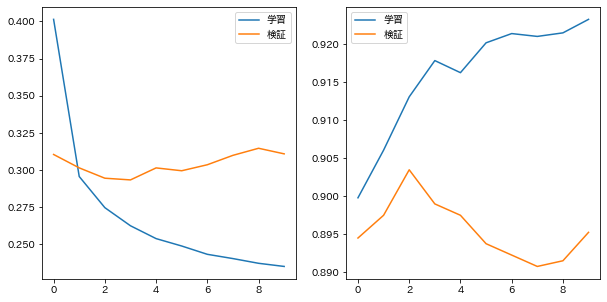

In [38]:
model = Perceptron(300, 4)
task = Task()
trainer = VerboseTrainer(model, loaders, task, 0.1, 10)
train_predictor = Predictor(trainer.model, Loader(test_dataset, 1))
valid_predictor = Predictor(trainer.model, Loader(test_dataset, 1))
trainer.train(train_v, train_t, valid_v, valid_t)

### 76. チェックポイント

問題75から改変してもいいけど，めんどうなので73からやる

In [39]:
import os

In [40]:
class LoggingTrainer(Trainer):
    def save(self, epoch):
        torch.save({'epoch' : epoch, 'optimizer': self.optimizer}, f'result/trainer_states{epoch}.pt')
        torch.save(self.model.state_dict(), f'result/checkpoint{epoch}.pt')
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            self.save(epoch)
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))

In [41]:
model = Perceptron(300, 4)
task = Task()
trainer = LoggingTrainer(model, loaders, task, 0.1, 10)
trainer.train()

epoch 0, train_loss:0.40303, valid_loss:0.31214
epoch 1, train_loss:0.29639, valid_loss:0.29592
epoch 2, train_loss:0.27451, valid_loss:0.29903
epoch 3, train_loss:0.26194, valid_loss:0.29984
epoch 4, train_loss:0.25443, valid_loss:0.29787
epoch 5, train_loss:0.24855, valid_loss:0.30021
epoch 6, train_loss:0.24384, valid_loss:0.30676
epoch 7, train_loss:0.24003, valid_loss:0.30658
epoch 8, train_loss:0.23756, valid_loss:0.30995
epoch 9, train_loss:0.23390, valid_loss:0.30879


In [42]:
! ls result/checkpoint*

result/checkpoint0.pt  result/checkpoint4.pt  result/checkpoint8.pt
result/checkpoint1.pt  result/checkpoint5.pt  result/checkpoint9.pt
result/checkpoint2.pt  result/checkpoint6.pt
result/checkpoint3.pt  result/checkpoint7.pt


In [43]:
! ls result/trainer_states*

result/trainer_states0.pt  result/trainer_states4.pt  result/trainer_states8.pt
result/trainer_states1.pt  result/trainer_states5.pt  result/trainer_states9.pt
result/trainer_states2.pt  result/trainer_states6.pt
result/trainer_states3.pt  result/trainer_states7.pt


### 77. ミニバッチ化

In [44]:
from time import time
from contextlib import contextmanager

In [45]:
@contextmanager
def timer(description):
    start = time()
    yield
    print(description, ': {:.3f} 秒'.format(time()-start))

In [46]:
B = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [47]:
task = Task()
for b in B:
    model = Perceptron(300, 4)
    loaders = (
        Loader(train_dataset, b, shuffle = True),
        Loader(valid_dataset, 1)
    )
    trainer = Trainer(model, loaders, task, 0.1 * b, 3)
    with timer(f'バッチサイズ {b}'):
        trainer.train()

epoch 0, train_loss:0.40374, valid_loss:0.31423
epoch 1, train_loss:0.29578, valid_loss:0.29623
epoch 2, train_loss:0.27499, valid_loss:0.29798
バッチサイズ 1 : 9.657 秒
epoch 0, train_loss:0.39955, valid_loss:0.31440
epoch 1, train_loss:0.29591, valid_loss:0.29844
epoch 2, train_loss:0.27373, valid_loss:0.29537
バッチサイズ 2 : 5.325 秒
epoch 0, train_loss:0.40296, valid_loss:0.31603
epoch 1, train_loss:0.29613, valid_loss:0.31031
epoch 2, train_loss:0.27469, valid_loss:0.29736
バッチサイズ 4 : 3.083 秒
epoch 0, train_loss:0.40289, valid_loss:0.31443
epoch 1, train_loss:0.29676, valid_loss:0.30920
epoch 2, train_loss:0.27498, valid_loss:0.30645
バッチサイズ 8 : 1.982 秒
epoch 0, train_loss:0.40211, valid_loss:0.31350
epoch 1, train_loss:0.29613, valid_loss:0.30777
epoch 2, train_loss:0.27449, valid_loss:0.29903
バッチサイズ 16 : 1.420 秒
epoch 0, train_loss:0.40343, valid_loss:0.32170
epoch 1, train_loss:0.29695, valid_loss:0.30777
epoch 2, train_loss:0.27486, valid_loss:0.29472
バッチサイズ 32 : 1.202 秒
epoch 0, train_loss:

### 78. GPU上での学習

In [48]:
device = torch.device('cuda')
train_dataset = Dataset(train_v, train_t)
valid_dataset = Dataset(valid_v, valid_t)
model = Perceptron(300, 4)
task = Task()
loaders = (
    Loader(train_dataset, 128, shuffle = True),
    Loader(valid_dataset, 1),
)
trainer = Trainer(model, loaders, task, 0.1 * 128, 3, device=device)
with timer('時間'):
    trainer.train()

epoch 0, train_loss:0.41928, valid_loss:0.31376
epoch 1, train_loss:0.30053, valid_loss:0.29341
epoch 2, train_loss:0.27865, valid_loss:0.29917
時間 : 1.433 秒


### 79. 多層ニューラルネットワーク

In [49]:
class ModelNLP79(nn.Module):
    def __init__(self, v_size, h_size, c_size):
        super().__init__()
        self.fc1 = nn.Linear(v_size, h_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(h_size, c_size)
        self.dropout = nn.Dropout(0.2)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

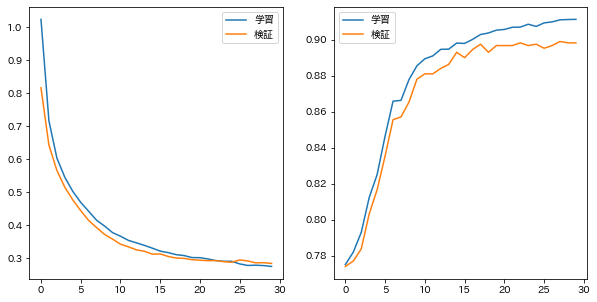

In [50]:
model = ModelNLP79(300, 128, 4)
task = Task()
loaders = (
    Loader(train_dataset, 128, shuffle = True),
    Loader(valid_dataset, 1)
)
trainer = VerboseTrainer(model, loaders, task, 0.1, 30)
trainer.train(train_v.to(device), train_t, valid_v.to(device), valid_t)